# Imports, Dataset loading

In [1]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from collections import defaultdict
import re
from scipy.signal import convolve2d


import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset, random_split
from torch.utils.data._utils.collate import default_collate
import torch.nn as nn
import torch.nn.functional as F


import ipywidgets as widgets
from ipywidgets import interact_manual
from ipywidgets import Layout, interact, widgets
from IPython.display import clear_output
import time
import beepy

# Loading the datasets from disk
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# loaded_dataset = load_preprocessed_data('preprocessed_data_giant.pkl')
loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands.pkl')
#loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands_22kres.pkl')

ground_truth_max = 200
ground_truth_min = 80
MAX_OCCURRENCES = 500


# Step 1: Filter data based on ground truth range
filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/20)]

label_dict = defaultdict(list)
for item in filtered_dataset:
    label = item[1].item()  # .item() ensures we're working with Python int, not a tensor
    label_dict[label].append(item)

# Step 3: Limit each label's items to max MAX_OCCURRENCES
limited_items = []
for label, items in label_dict.items():
    limited_items_for_label = items[:MAX_OCCURRENCES]
    limited_items.extend(limited_items_for_label)

# Step 4: Construct the final dataset (this will be a list, not a ConcatDataset)
filtered_dataset = limited_items
print("dataset length after filtering: ", len(filtered_dataset))

###############################################

train_data_ratio = 0.9
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_loader.dataset[0][0].squeeze(0).shape
num_classes = ground_truth_max-ground_truth_min+1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of cores used: 15
dataset length after filtering:  45479


## preprocessing Dataset, spatial & temporal binning etc

In [2]:
# import default collate function
from torch.utils.data._utils.collate import default_collate
from scipy.signal import convolve2d

def frequency_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_bands = n_bands // bin_size
    binned_mel = np.zeros((binned_bands, n_frames))
    
    for i in range(binned_bands):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[start_idx:end_idx, :]
        
        if aggregation == 'mean':
            binned_mel[i, :] = np.mean(bin_data, axis=0)
        elif aggregation == 'sum':
            binned_mel[i, :] = np.sum(bin_data, axis=0)
        elif aggregation == 'min':
            binned_mel[i, :] = np.min(bin_data, axis=0)
        elif aggregation == 'max':
            binned_mel[i, :] = np.max(bin_data, axis=0)
        elif aggregation == 'median':
            binned_mel[i, :] = np.median(bin_data, axis=0)
        elif aggregation == 'std':
            binned_mel[i, :] = np.std(bin_data, axis=0)
        elif aggregation == 'rms':
            binned_mel[i, :] = np.sqrt(np.mean(bin_data**2, axis=0))
        elif aggregation == 'low_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.1, axis=0)
        elif aggregation == 'high_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.9, axis=0)
    
    return binned_mel

def time_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_frames = n_frames // bin_size
    binned_mel = np.zeros((n_bands, binned_frames))
    
    for j in range(binned_frames):
        start_idx = j * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[:, start_idx:end_idx]
        
        if aggregation == 'mean':
            binned_mel[:, j] = np.mean(bin_data, axis=1)
        elif aggregation == 'sum':
            binned_mel[:, j] = np.sum(bin_data, axis=1)
        elif aggregation == 'min':
            binned_mel[:, j] = np.min(bin_data, axis=1)
        elif aggregation == 'max':
            binned_mel[:, j] = np.max(bin_data, axis=1)
        elif aggregation == 'median':
            binned_mel[:, j] = np.median(bin_data, axis=1)
        elif aggregation == 'std':
            binned_mel[:, j] = np.std(bin_data, axis=1)
        elif aggregation == 'rms':
            binned_mel[:, j] = np.sqrt(np.mean(bin_data**2, axis=1))
        elif aggregation == 'low_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.1, axis=1)
        elif aggregation == 'high_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.9, axis=1)
    
    return binned_mel

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def vertical_edge_kernel(size=5):
    kernel = np.zeros((size, size))
    mid = size // 2
    kernel[:, mid] = 1
    return kernel

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return default_collate(batch)

def energy_distribution(mel_spectrogram_normalized):
    total_energy = np.sum(mel_spectrogram_normalized ** 2)
    if total_energy == 0:
        return np.zeros_like(mel_spectrogram_normalized.shape[0])
    energy_per_band = np.sum(mel_spectrogram_normalized ** 2, axis=1)
    distribution = energy_per_band / total_energy
    return distribution

def energy_distribution_variance(mel_spectrogram_normalized):
    distribution = energy_distribution(mel_spectrogram_normalized)
    return np.var(distribution)

def compute_bandwise_thresholds(single_mel, low_factor=0.5, mid_factor=1.0, high_factor=1.5, n_windows=5):
    """
    Compute dynamic thresholds for each individual mel band of the mel spectrogram using a local window.
    
    Parameters:
    - single_mel: Mel spectrogram segment.
    - low_factor: Emphasis factor for the bass bands.
    - mid_factor: Emphasis factor for the mid-frequency bands.
    - high_factor: Emphasis factor for the high-frequency bands.
    - n_windows: Number of frames to consider on each side of the current frame for local averaging.

    Returns:
    - List of thresholds for each mel band.
    """
    n_bands, n_frames = single_mel.shape
    thresholds = np.zeros_like(single_mel)

    # Defining the indices for each category
    low_end = n_bands // 3  # First third is low
    mid_end = 2 * n_bands // 3  # Second third is mid
    window_size = n_frames // n_windows
    half_window = window_size // 2
    
    for i in range(n_bands):
        for j in range(n_frames):
            start = max(0, j - half_window)
            end = min(n_frames, j + half_window + 1)
            
            avg_energy = np.mean(single_mel[i, start:end])  # Local average energy

            # Applying the emphasis factor based on the band's category
            if i < low_end:
                thresholds[i, j] = avg_energy * low_factor
            elif i < mid_end:
                thresholds[i, j] = avg_energy * mid_factor
            else:
                thresholds[i, j] = avg_energy * high_factor
                
    return thresholds

def transform_mel(single_mel, low_factor=0.07, mid_factor=0.09, high_factor=0.1, n_windows=5):
    # Convert tensor to numpy
    single_mel = single_mel.cpu()
    
    single_mel = librosa.power_to_db(single_mel, ref=np.max, amin=1e-5, top_db=90.0)
    single_mel = librosa.db_to_power(single_mel)
    
    n_fft = 2048
    hop_size = n_fft // 4
    sample_rate = 22050
    n_frames_unbinned = single_mel.shape[1]
    total_samples = hop_size * (n_frames_unbinned - 1)
    mel_duration = total_samples / sample_rate
    
    single_mel_db = single_mel
    single_mel_db = np.asarray(single_mel_db)
    vertical_kernel = vertical_edge_kernel(7)
    filtered_mel = convolve2d(single_mel, vertical_kernel, mode='valid')
    
    frequency_bin_size = int(filtered_mel.shape[0] / 16)
    frequency_binned_mel = frequency_binning(filtered_mel, bin_size=frequency_bin_size, aggregation='rms')
    # Time Between Beats= 60 seconds / 210 beats = 0.2857 seconds/beat
    frame_duration = mel_duration / n_frames_unbinned  # Current time resolution per frame
    
    max_bpm_possible = 210
    time_between_beats = 60 / max_bpm_possible  # Time between beats in seconds
    desired_resolution = time_between_beats / 6  # Half of the time between beats for 210 BPM
    time_bin_size = int(desired_resolution / frame_duration)
    time_binned_mel = time_binning(frequency_binned_mel, bin_size=time_bin_size, aggregation='rms')
    
    time_binned_mel_normalized = (time_binned_mel) - np.min(time_binned_mel) / (np.max(time_binned_mel) - np.min(time_binned_mel))
    ENTROPY_THRESHOLD = 2.0
    energy_variance = energy_distribution_variance(time_binned_mel_normalized) * 100
    is_energy_evenly_distributed = energy_variance < ENTROPY_THRESHOLD
    is_valid = not is_energy_evenly_distributed
        
    diffs = np.diff(time_binned_mel_normalized, axis=1)
    n_bands, n_frames = time_binned_mel_normalized.shape
    
    thresholds = compute_bandwise_thresholds(time_binned_mel_normalized, low_factor=low_factor, mid_factor=mid_factor, high_factor=high_factor, n_windows=5)

    positive_event_img = np.zeros_like(time_binned_mel_normalized)[:, :-1]
    negative_event_img = np.zeros_like(time_binned_mel_normalized)[:, :-1]

    for i in range(n_bands):
        for j in range(n_frames - 1):  # diffs is one frame shorter
            if np.abs(diffs[i, j]) >= thresholds[i, j]:
                polarity = 1 if diffs[i, j] > 0 else -1
                if polarity == 1:
                    positive_event_img[i, j] = 1
                else:
                    negative_event_img[i, j] = 1
                      
                    
    return positive_event_img, negative_event_img, is_valid


class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        positive, negative, is_valid = transform_mel(mel.squeeze(0))
        
           # Prüfung auf ausreichende Entropie
        if not is_valid:
            return None
        # positive = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive, negative], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa
    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_dataset)
transformed_val_dataset = TransformedDataset(val_dataset)

# Create DataLoaders
batch_size_new = 128

train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape


torch.Size([2, 19, 101])


## CNN & SNN Hybrid architecture, optimizer, criterion

In [3]:
# dualchannel SNN

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        self.surr_grad = surrogate.FastSigmoid.apply
        self.apply_inhibition = False

        # First convolutional layer
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.lif1 = snn.Leaky(beta=0.2)

        # Pooling
        self.pool = nn.AvgPool2d(2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.lif2 = snn.Leaky(beta=0.2)

        # Fully connected layer
        self.fc1_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        # self.fc1_size = 278528
        # self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2)

        # Output layer
        self.fc2 = nn.Linear(1000, num_classes)
        
        
               # Lateral inhibition
        self.inhib = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        with torch.no_grad():
            self.inhib.weight[:] = 0.05  
            self.inhib.weight[:, :, 1, 1] = -0.5  


    def forward(self, x, mem=None):
        if mem is None:
            mem = {
                'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, x.size(2)//2, x.size(3)//2, device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }

        # First convolutional layer
        x, mem['conv1'] = self.lif1(self.conv1(x), mem['conv1'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Second convolutional layer
        x, mem['conv2'] = self.lif2(self.conv2(x), mem['conv2'])
        if self.apply_inhibition:
            x = x + self.inhib(x) # Apply lateral inhibition only if apply_inhibition is True
            x = self.surr_grad(x)
        x = self.pool(x)

        # Flatten for the fully connected layer
        x = x.view(-1, self.fc1_size)

        # Fully connected layer
        x, mem['fc1'] = self.lif3(self.fc1(x), mem['fc1'])
        x = self.surr_grad(x)

        # Output layer
        x = self.fc2(x)
        
        return x, mem


# Define your SNN model
criterion = nn.CrossEntropyLoss()
model = SpikingNet(input_shape, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

In [7]:
model_load_path = "SCNN_TEMPO__GIANTSTEP_FIN.pth"
model = SpikingNet(input_shape, num_classes=num_classes)
model.load_state_dict(torch.load(model_load_path))
model.to(device)

SpikingNet(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif1): Leaky()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif2): Leaky()
  (fc1): Linear(in_features=5120, out_features=1000, bias=True)
  (lif3): Leaky()
  (fc2): Linear(in_features=1000, out_features=121, bias=True)
  (inhib): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

## Training with Early Stopping

In [4]:
# # Training parameters
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

early_stopping = EarlyStopping(patience=10)
#train_loader = DataLoader(train_loader.dataset, batch_size=200, shuffle=True, drop_last=True)
num_batches = len(train_loader)

start_time_all = time.time()

num_epochs = 30
time_steps = 3
epochs_without_inhibition = 5

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
                
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        if epoch > epochs_without_inhibition:
            model.apply_inhibition = True
        
        estimated_min = estimated_remaining_time/60
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs or {estimated_min:.1f} mins", end='\r')

    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{num_epochs} epochs took {end_time/60.0:.2f} mins")

num_epochs = 8
train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new*2, shuffle=True, collate_fn=collate_fn)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
                
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        if epoch > epochs_without_inhibition:
            model.apply_inhibition = True
        
        estimated_min = estimated_remaining_time/60
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs or {estimated_min:.1f} mins", end='\r')

    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break


Epoch 1/30, Batch 320/320, Loss: 4.2487, Est. Remaining Time: 0.00 secs or 0.0 minsss
Epoch 1/30, Training Loss: 4.5624, Accuracy: 2.15%, took 801.31 seconds
Estimated Total Time: 400.66 mins, Remaining Time: 387.30 mins
Epoch 2/30, Batch 320/320, Loss: 3.7391, Est. Remaining Time: 0.00 secs or 0.0 minsss
Epoch 2/30, Training Loss: 4.1285, Accuracy: 6.44%, took 798.75 seconds
Estimated Total Time: 399.38 mins, Remaining Time: 372.75 mins
Epoch 3/30, Batch 320/320, Loss: 3.4668, Est. Remaining Time: 0.00 secs or 0.0 minsss
Epoch 3/30, Training Loss: 3.6755, Accuracy: 13.02%, took 789.39 seconds
Estimated Total Time: 394.69 mins, Remaining Time: 355.22 mins
Epoch 4/30, Batch 320/320, Loss: 3.1729, Est. Remaining Time: 0.00 secs or 0.0 minsss
Epoch 4/30, Training Loss: 3.2297, Accuracy: 20.55%, took 803.13 seconds
Estimated Total Time: 401.56 mins, Remaining Time: 348.02 mins
Epoch 5/30, Batch 320/320, Loss: 2.4924, Est. Remaining Time: 0.00 secs or 0.0 minsss
Epoch 5/30, Training Loss: 2

KeyboardInterrupt: 

In [13]:
num_epochs = 4
new_betsch = batch_size_new * 2
print(new_betsch)
start_time_all = time.time()
train_loader = DataLoader(transformed_train_dataset, batch_size=new_betsch, shuffle=True, collate_fn=collate_fn)
num_batches = len(train_loader)
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
                
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        if epoch > epochs_without_inhibition:
            model.apply_inhibition = True
        
        estimated_min = estimated_remaining_time/60
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs or {estimated_min:.1f} mins", end='\r')

    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break

256


KeyboardInterrupt: 

In [12]:
model_save_path = f"SCNN_TEMPO__GIANTSTEP_FIN_reduced.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to SCNN_TEMPO__GIANTSTEP_FIN_reduced.pth


## evaluation + plots

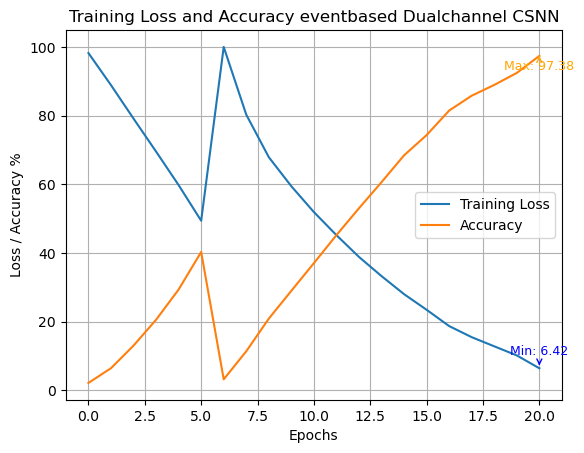

In [8]:
def min_max_normalize(arr):
    return (arr - 0) / (np.max(arr) - 0)

norm1 = min_max_normalize(np.array(epoch_losses)) * 100
norm2 = np.array(training_accuracies) 

# Get the global min for loss and its corresponding index
loss_min_index = np.argmin(norm1)
loss_min_value = norm1[loss_min_index]

# Get the global max for accuracy and its corresponding index
accuracy_max_index = np.argmax(norm2)
accuracy_max_value = norm2[accuracy_max_index]

# Plotting
plt.plot(norm1, label="Training Loss")
plt.plot(norm2, label="Accuracy")
plt.grid(True)
plt.title("Training Loss and Accuracy eventbased Dualchannel CSNN")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy %")

# Annotate the minimum loss
plt.annotate(f'Min: {loss_min_value:.2f}', 
             (loss_min_index, loss_min_value), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center', 
             fontsize=9, 
             color='blue', 
             arrowprops=dict(arrowstyle='->', color='blue'))

# Annotate the maximum accuracy
plt.annotate(f'Max: {accuracy_max_value:.2f}', 
             (accuracy_max_index, accuracy_max_value), 
             textcoords="offset points", 
             xytext=(0,-10), 
             ha='center', 
             fontsize=9, 
             color='orange', 
             arrowprops=dict(arrowstyle='->', color='orange'))

plt.legend()
plt.show()


In [9]:
def is_SNN(model):
    for name, module in model.named_modules():
        if isinstance(module, snn.Leaky):
            return True
    return False


all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  
model_type = 'SCNN' if is_SNN(model) else "CNN"
time_steps = 3


# Set model to evaluation mode
model.eval()
# No gradient is needed during evaluation/inference

with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        data = data.to(device)
        target_zero_indexed = target.to(device) - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(data, mem)

        predictions = torch.argmax(outputs, dim=1) + ground_truth_min
        confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)[0].cpu().numpy()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(target.cpu().numpy())
        all_confidences.extend(confidences)
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

beepy.beep(sound=1)  # 1 for 'coin'

In [10]:
def visualize_based_on_threshold(threshold=0.5, tolerance=1.0):
    # Clear previous plots
    clear_output(wait=True)
    
    # Filter based on confidence threshold
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
    correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
    correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
    accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
    std_deviation_model = np.std(filtered_true_labels - filtered_predictions)
    std_deviation_librosa = np.std(all_true_labels - librosa_bpm_estimates)
        # Adding the ground truth line
    min_val = min(np.min(all_true_labels), np.min(all_predictions))
    max_val = max(np.max(all_true_labels), np.max(all_predictions))
    

    print(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
    print(f"cnt  {len(filtered_predictions)}/{len(all_true_labels)}")
    # Update your scatter plot or any other visualizations using high_confidence_indices
    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_labels[high_confidence_indices], all_predictions[high_confidence_indices], color='red', alpha=0.3, label='Model Predictions')
    plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
    plt.axhline(y=0, color='k', linestyle='--')
    plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Ground Truth')

    plt.title(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {filtered_accuracy:.2f}% (std: {std_deviation_model:.2f})\n" 
              f"Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}% (std: {std_deviation_librosa:.2f})\n" 
              f"confidence threshold: {threshold}\n after {len(epoch_losses)} epochs")
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    

    plt.show()
       
# Define and display slider
threshold_slider = widgets.FloatSlider(value=0.5, min=0, max=0.99, step=0.01, description='Confidence Threshold:')
tolerance_slider = widgets.IntSlider(value=1, min=1, max=30, step=1, description='Tolerance:')
widgets.interactive(visualize_based_on_threshold, threshold=threshold_slider, tolerance=tolerance_slider)

interactive(children=(FloatSlider(value=0.5, description='Confidence Threshold:', max=0.99, step=0.01), IntSli…

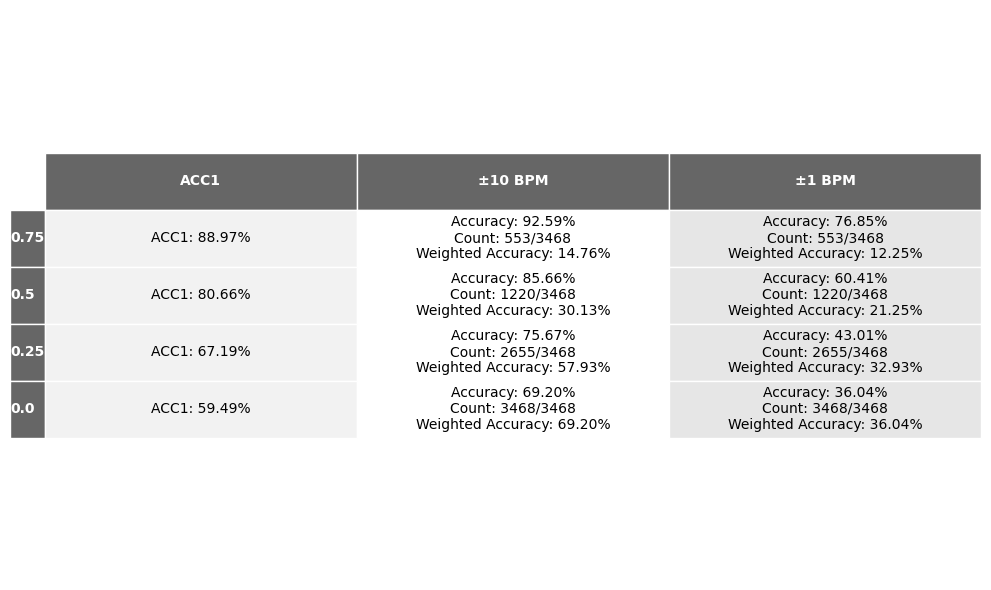

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_metrics(threshold):
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    
    acc1 = compute_ACC1(filtered_predictions, filtered_true_labels)
    metrics = {
        'acc1': acc1,
        'counts': []
    }
    
    for tolerance in [10, 1]:
        filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
        count = len(filtered_predictions)
        weighted_accuracy = (filtered_accuracy * count) / len(all_true_labels)
        metrics['counts'].append((filtered_accuracy, count, weighted_accuracy))
    
    return metrics

def compute_ACC1(predictions, true_labels, tolerance_ratio=0.04):
    """Compute ACC1 given predictions and true labels."""
    errors = np.abs(predictions - true_labels) / true_labels
    return np.mean(errors <= tolerance_ratio) * 100

def plot_table():
    confidences = [0.75, 0.5, 0.25, 0]
    metrics_data = []
    
    for threshold in confidences:
        metrics_data.append(compute_metrics(threshold))

    columns = ['ACC1', '±10 BPM', '±1 BPM']
    df = pd.DataFrame(index=confidences, columns=columns)

    for i, threshold in enumerate(confidences):
        df.at[threshold, 'ACC1'] = f"ACC1: {metrics_data[i]['acc1']:.2f}%"
        for j, tol in enumerate([10, 1]):
            df.at[threshold, f"±{tol} BPM"] = (f"Accuracy: {metrics_data[i]['counts'][j][0]:.2f}%"
                                              f"\nCount: {metrics_data[i]['counts'][j][1]}/{len(all_true_labels)}"
                                              f"\nWeighted Accuracy: {metrics_data[i]['counts'][j][2]:.2f}%")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    
    # Fixing the cellColours list
    cell_colors = []
    for _ in range(len(df)):
        cell_colors.append(["#f2f2f2", "#ffffff", "#e6e6e6"])

    # Using a gray background color for the table and alternating row colors for clarity
    the_table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
                         cellLoc='center', loc='center', 
                         cellColours=cell_colors,
                         colColours=["#666666"] * len(df.columns),
                         rowColours=["#666666"] * len(df))
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.2)
    for (i, j), cell in the_table.get_celld().items():
        if i == 0 or j == -1:
            cell.set_text_props(fontweight='bold', color='w')
        cell.set_edgecolor('w')
        
    # Adjust cell padding
    cellDict = the_table.get_celld()
    for key in cellDict:
        cellDict[key].set_height(0.1)  # Adjust as needed
        cellDict[key].PAD = 0.01  # Adjust as needed
        
    plt.tight_layout()
    plt.show()

plot_table()

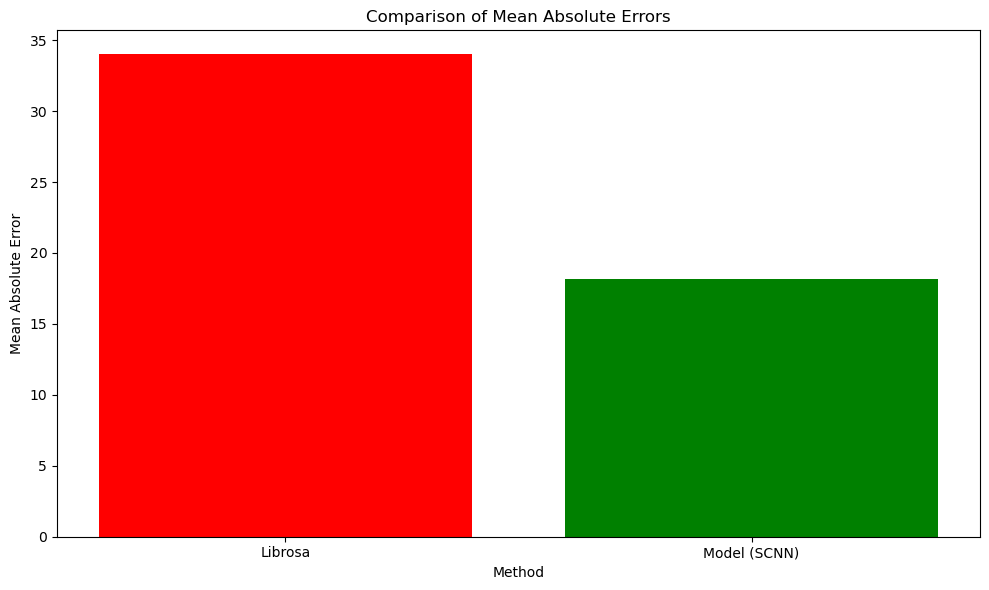

In [9]:
# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))

# Plot Mean Absolute Errors
model_label = f'Model ({model_type})'
labels = ['Librosa', model_label]
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()